# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [145]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
#data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(data.head())
display(data.info())
display(data.isna().sum())
display(data.isna().mean())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

### Вывод

В исследуемом датасете 23699 строк, 22 колонки со значениями, имеются все типы данных. В большинстве серий есть пропуски, где-то они составляют даже больше половины значений. С ними нужно будет разобраться, возможно где-то они "естественны" или есть смысл проигнорировать, а где-то их лучше будет заменить. Так же тип данных некоторых колонок определен неверно или некорреткно, тоже стоит рассмотреть их и заменить при необходимости.

## Предобработка данных

**is_apartment**

В этом столбце самая большая доля пропусков, почти 90%. Заменим все пропуски на True, если в столбце living_area этой же строки у нас -  не пропуск. Затем поменяем тип данных на bool в этом столбце. Ссылаясь на то, что если указана жилая площадь, значит эта недвижимость предназначена для жилья(то есть апартаменты). Сочтем, что жилой дом тоже апартаменты. Если так можно сейчас.

**balcony**

В этом столбце тоже большое количество пропусков, почти 50%. Предположим, что каждый пропуск это отсутствие балкона и заменим его значение на "0". 

**ceiling_height**

Данный столбец тоже имеет большое количество пропусков. Но мы его проигнорируем, ибо это может исказить наше дальнейшее исследование.

**days_exposition**

Заменим пропуски на медианное значение по столбцу.

**parks_around3000, ponds_around3000**

Заменим пропуски на 0, посчитаем, что в этом районе нет парков и водоёмов.

**floors_total**

Заменим пропуски на 1, чтобы мы могли применить тип int ко всем значениям, ибо доля пропусков в этом столбце крайне мала.

**airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest, days_exposition, kitchen_area, living_area, locality_name**

Пропуски в этих столбцах достаточно большие, но мы их проигнорируем. Трудно сейчас утверждать, каким значением праивильно будет заполнить данные пропуски.


In [146]:
# Тут я решил, что надо как-то по умному заменить пропуски в ceiling_height

# Создал сводную таблицу из количества комнат и среднего значения высоты потолков
ceiling_height_median = data.pivot_table(index='rooms', values='ceiling_height', aggfunc=('median'))
display(ceiling_height_median.head())

# Создал из этой сводной таблицы словарь по типу Кол-во комнат: средняя высота потолков
ceiling_height_median_dict = {}
for room, ceiling_height in ceiling_height_median.groupby('rooms')['ceiling_height']:
    ceiling_height_median_dict[room] = ceiling_height[room]
    
# Посчитал первоначальное количество пропусков
display(data['ceiling_height'].isna().sum())

# Заменил все пропуски на 0
data['ceiling_height'] = data['ceiling_height'].fillna(0)

# Создал функцию с заменой всех 0 значений в датафрейме на среднее значение соответствующего
# кол-ва комнат из словаря
def no_ceiling_height_nan(row):
    rooms_data = row['rooms']
    ceiling_height_data = row['ceiling_height']
    try:
        if ceiling_height_data == 0:
            ceiling_height_data = ceiling_height_median_dict[rooms_data]
        return ceiling_height_data
    except:
        return 0

# Применил эту функцию к датафрейму
data['ceiling_height'] = data.apply(no_ceiling_height_nan, axis=1)

# Посчитал количество строк, в кторых осталось нулевое значение
display(data[data['ceiling_height'] == 0]['ceiling_height'].count())

# Посчитал количество уникальных населенных пунктов в словаре и в датафрейме в целом, чтобы сравнить результат
display(len(ceiling_height_median_dict))
display(len(data['rooms'].unique()))

# Изучим пропуски и их количество в столбце is_apartment, и заполним их. 
#display(data['is_apartment'].value_counts())

def is_apartment(row):
    apartment = row['is_apartment']
    living_area = row['living_area']
    if np.isnan(living_area) == False and apartment != False:
        apartment = True
    return apartment
    
data['is_apartment'] = data.apply(is_apartment, axis=1)

,ceiling_height
rooms,
0,2.75
1,2.64
2,2.60
3,2.65
4,2.80


9195

1

16

17

In [147]:
# Заменим в столбце ceiling_height тип на bool.
# data['ceiling_height'] = data['ceiling_height'].fillna(0)

# Заменим в столбце is_apartment тип на bool.
data['is_apartment'] = data['is_apartment'].fillna('False').astype('bool')
#display(data['is_apartment'].value_counts())

# Изучим пропуски и их количество в столбце balcony. Заменим сразу тип на int и пропуски на 0.
# display(data['balcony'].unique())
data['balcony'] = data['balcony'].fillna(0.0).astype('int')

# Изучим пропуски и их количество в столбце days_exposition. 
# Заменим сразу тип на int и пропуски на медианное.
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median()).astype('int')

# Изучим пропуски и их количество в столбцах parks_around3000 и ponds_around3000. Заменим сразу тип на int и пропуски на 0.
#display(data[np.isnan(data['parks_around3000']) == True])
data['parks_around3000'] = data['parks_around3000'].fillna(0.0).astype('int')
data['ponds_around3000'] = data['ponds_around3000'].fillna(0.0).astype('int')

# Изучим пропуски и их количество в столбце floors_total. Заменим сразу тип на int и пропуски на 0.
data['floors_total'] = data['floors_total'].fillna(1.0).astype('int')

In [148]:
# Заменим тип данных в столбц last_price на int
data['last_price'] = data['last_price'].astype('int')

* **last_price** - заменили тип днных на int, ссылась на то, что сумма указана без "копеек".
* **balcony** — заменили тип данных на int, потому что количество балконов не может быть дробным. Унас либо есть 1, либо 2, либо 3 и т.д. балконов, либо их нет (0).
* **days_exposition** — заменили на тип int, ссылаясь на то, что считать дробную часть дня нерационально
* **floors_total** — заменили на тип int, потому что количество этажей может быть только целое. Если это какой-то особый сучай, то уже будет указываться в отдельном столбце "примечание", напрмиер, при заполнении данных пользователем.
* **is_apartment** — заменили на bool, потому что нам нужно знать "да" - это апартаменты (True) или нет - (False)
* **parks_around3000** — заменили на тип int, потому что количество парков может быть только целое.
* **ponds_around3000** — заменили на тип int, потому что количество водоёмов может быть только целое.




## Расчёты и добавление результатов в таблицу

In [149]:
# Расчет цены квадратного метра
data['cost_meter'] = data['last_price'] / data['total_area']

# День недели, месяц и год публикации объявления
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')

data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

# Этаж квартиры
def floor_type(row):
    floor = row['floor']
    max_floor = row['floors_total']
    if floor == 1:
        return 'Первый'
    elif floor == max_floor:
        return 'Последний'
    else:
        return 'Другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

# Соотношение жилой и общей площади
data['living_per_total'] = data['living_area'] / data['total_area']

# Соотношение площади кухни к общей площади
data['kitchen_per_total'] = data['kitchen_area'] / data['total_area']

display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,cost_meter,weekday,month,year,floor_type,living_per_total,kitchen_per_total
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,2,755.0,95,120370.370370,3,3,2019,Другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.64,11,18.6,1,True,...,0,NaN,81,82920.792079,1,12,2018,Первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.60,5,34.3,4,True,...,2,574.0,558,92785.714286,3,8,2015,Другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,2.65,14,NaN,9,True,...,3,234.0,424,408176.100629,4,7,2015,Другой,NaN,NaN
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,1,48.0,121,100000.000000,1,6,2018,Другой,0.320000,0.410000


## Исследовательский анализ данных

### Изучите следующие параметры:
площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

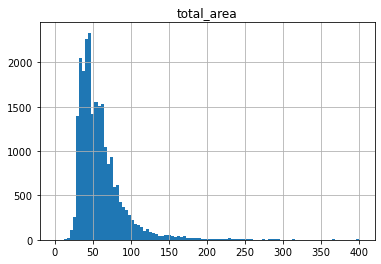

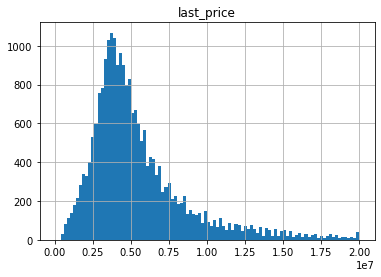

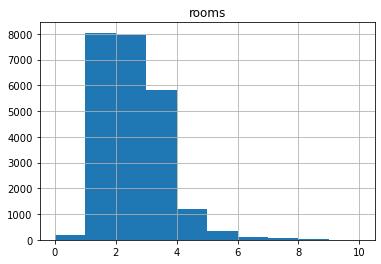

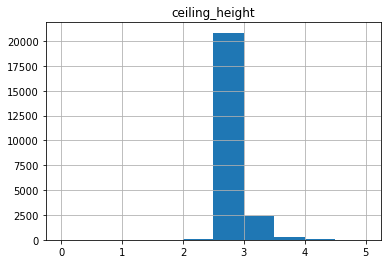

In [150]:
# Гистрограмма для площади
data.hist('total_area', bins=100, range=(0, 400))

# Гистрограмма для wtys
data.hist('last_price', bins=100, range=(0, 20000000))

# Гистрограмма для числа комнат
data.hist('rooms', range=(0,10))

# Гистрограмма для высоты потолков
data.hist('ceiling_height', bins=10, range=(0,5))
#display(data['ceiling_height'].value_counts().sort_values())

Было проделано огромное количесво итераций для определения хорошего количества корзин, чтобы чуть более наглядно понимать, распределение большинства значений.

Так было определено, что:
* Большая часть недвижимости от 25 до 75 квадратов, пик в 40-50 квадратов
* Большая часть недвижимости в датасете стоит от 2,5 до 6млн рублей, пик 3-4млн рублей
* Больше всего продаются жил. площади с 1-2 комнатами и не сильно уступают им 3х комнатные
* Больше всего недвижимости с потолками от 2,5 до 3 метров

### Изучите время продажи квартиры.
Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

1

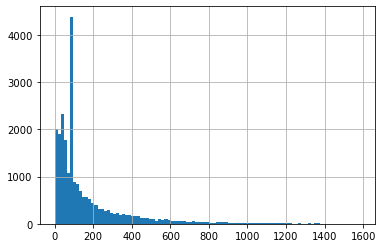

In [151]:
display(data['days_exposition'].describe())
data['days_exposition'].hist(bins=100)
# data['days_exposition'].hist(bins=100, range=(0,150))
display(data[data['days_exposition'] == 1]['days_exposition'].sum())

* Среднее равно = 169.360226, медиана = 95.000000. 
* Пик "быстроты" продаж занимает диапозон от 0-100 дней продажи. 
* Самая быстрая и долгая продажи так же 1 день и 1580.

Все продажи, что прошли раньше, чем 100 дней - можно считать достаточно быстрыми, а те что дольше 199 дней - аномально долгими (например 1580 дней, почти 5 лет)

Так же можно увидеть три интересных пика на отрезке от 30-100 дней. За 95 дней продалось более 3000 объектов недвижимости.

### Уберите редкие и выбивающиеся значения.
Опишите, какие особенности обнаружили.

In [152]:
# new_data = data.query('days_exposition > =45 and days_exposition <= 199')
# new_data['days_exposition'].hist()

display(data['total_area'].describe())

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [153]:
# 1.5 * IQR = 1.5 * (69-12) = 43.5. левый ус = 0, правый ус = 112,5
new_data = data.query('total_area <= 112.5')

display(data['last_price'].describe())

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [154]:
# 1.5 * IQR = 1.5 * (6.8-3.4)*10^6 = 5.1. левый ус = 0, правый ус = 1,19 *10^7
new_data = new_data.query('last_price <= 11.9 * 10 ** 6')

display(data['rooms'].describe())
new_data.shape

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

(21451, 29)

In [155]:
# 1.5 * IQR = 1.5 * (3-1) = 3. левый ус = 0, правый ус = 6
new_data = new_data.query('rooms <= 6')

display(data['ceiling_height'].describe())
new_data.shape

count    23699.000000
mean         2.722425
std          0.989851
min          0.000000
25%          2.600000
50%          2.640000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

(21451, 29)

In [156]:
# 1.5 * IQR = 1.5 * (2.7-2.6) = 0.15. левый ус = 2.45, правый ус = 2.85
new_data = new_data.query('ceiling_height >= 2.45 and ceiling_height <= 2.85')

display(new_data['ceiling_height'].value_counts())
new_data.shape

2.60    4598
2.64    3501
2.50    3479
2.65    2408
2.70    1484
2.80    1046
2.55     973
2.75     941
2.56     138
2.57     101
2.85      83
2.54      82
2.52      79
2.53      67
2.58      62
2.77      55
2.76      51
2.78      44
2.67      36
2.51      34
2.74      26
2.72      24
2.73      23
2.68      23
2.66      17
2.84      16
2.82      16
2.45      15
2.59      14
2.62      12
2.63      12
2.83      11
2.71      11
2.79       9
2.81       8
2.48       8
2.61       5
2.47       3
2.46       2
2.69       2
2.49       1
Name: ceiling_height, dtype: int64

(19520, 29)

После "отсечения" редких и выбивающихся значений, у нас остался датасет с данными в следующих диапазонах:

Общей площадью от 0 до 112,5 квадратных метров, стоимостью до 11,9 млн рублей; с кол-вом комнат  до 6; и высостой потолков от 2.45 до 2.85 метров.

#### Зависимость цены от площади

0.6772886526996743


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

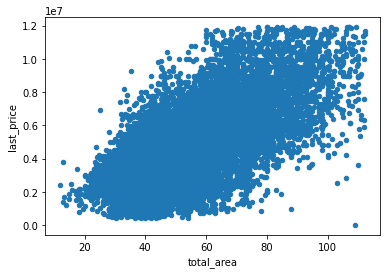

In [157]:
print(new_data['total_area'].corr(new_data['last_price']))
new_data.plot(x='total_area', y='last_price', kind='scatter')


Полученный коэффициент корреляции равен 0,53. Такой коэффциент может лишь сказать, что есть средняя прямая зависимость цены от площади объекта недвижимости. А из графика по нашему новому датасету видно, что однозначной прямой зависимости нет. Так как есть объекты разных площадей и разных цен соотвественно, т.е. есть большие объекты дешевые и дорогие и средней цены, так же есть маленькие объекты во всем ценновом диапозоне и т.д.

#### Зависимость цены от количества комнат

,last_price
rooms,
0,2700000
1,3550000
2,4505000
5,5450000
3,5500000
4,5996500
6,7982000


<AxesSubplot:xlabel='rooms'>

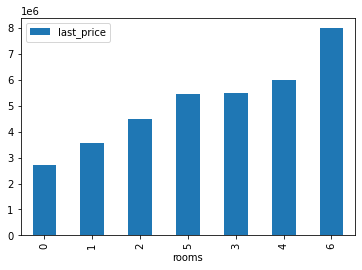

In [158]:
new_data_rooms = new_data.pivot_table(index='rooms', values='last_price', aggfunc='median').sort_values(by='last_price')
display(new_data_rooms)
new_data_rooms.plot(y='last_price', kind='bar')

#new_data.boxplot(column='rooms')

# print(new_data['rooms'].corr(new_data['last_price']))
# new_data.plot(x='rooms', y='last_price', kind='scatter')

Из полученного графика видим, что по медианной цене 1-комнатные объекты продаются гораздо дешевле, чем, например, трех-комнатные.

#### Зависимость цены от расстояния до центра

-0.3055003662232496


<AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>

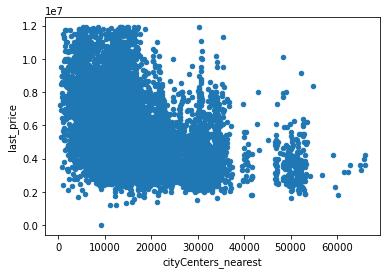

In [159]:
print(new_data['cityCenters_nearest'].corr(new_data['last_price']))
new_data.plot(x='cityCenters_nearest', y='last_price', kind='scatter')

# new_citynearest_data = data.query('last_price <= 1.5 * 10 ** 8')
# print(new_citynearest_data['cityCenters_nearest'].corr(new_citynearest_data['last_price']))
# new_citynearest_data.plot(x='cityCenters_nearest', y='last_price', kind='scatter')

Хоть и коэффицент корреляции отрицательный и близок к нулю (-0.25) из графика мы видим, что в разы больше объектов недвижимости в районе от 8км до 20км и они с большей вероятностью стоят дороже чем те, что находятся на расстоянии больше 40км от центра.

#### Зависимость цены от этажности

,last_price
floor_type,
Первый,3600000
Последний,3800000
Другой,4450000


<AxesSubplot:xlabel='floor_type'>

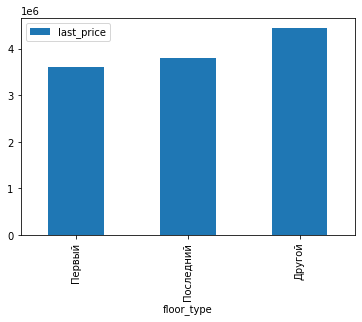

In [160]:
new_data_floor = new_data.pivot_table(index='floor_type', values='last_price', aggfunc='median').sort_values(by='last_price')
display(new_data_floor)
new_data_floor.plot(y='last_price', kind='bar')

# data['neww'] = data['floor_type']
# data['neww'].replace(['Первый', 'Другой', 'Последний'], [0,1,2], inplace=True)
# print(data['neww'].corr(data['last_price']))
# data.plot(x='neww', y='last_price', kind='scatter')


Из полученного графика видим, что по медианной цене объекты, находящиеся на первом этаже продаются дешевле, чем объекты, находящиеся на других этажах, кроме последнего.

#### Зависимость цены от дня недели

         last_price
weekday            
0           4300000
1           4250000
2           4300000
3           4200000
4           4200000
5           4248000
6           4250000


<AxesSubplot:xlabel='weekday'>

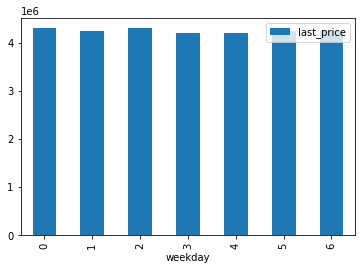

In [161]:
new_data_weekday = new_data.pivot_table(index='weekday', values='last_price', aggfunc='median')
print(new_data_weekday)
new_data_weekday.plot(y='last_price', kind='bar')

# print(data['weekday'].corr(data['last_price']))
# data.plot(x='weekday', y='last_price', kind='scatter')


На графике видим, что ярковыраженной зависимости цены от дня недели продажи нет. Можно отметить, что по медианной цене в выходные дни и вторники объекты продаются чуть дороже, возможно люди чуть добрее в эти дни. А в четверг и среду, наоборот объекты продаются чуть дешевле, видимо, наоборот продавцы более щедры.

#### Зависимость цены от месяца

       last_price
month            
1       4243000.0
2       4216697.5
3       4300000.0
4       4435000.0
5       4250000.0
6       4100000.0
7       4190000.0
8       4200000.0
9       4275000.0
10      4220000.0
11      4300000.0
12      4250000.0


<AxesSubplot:xlabel='month'>

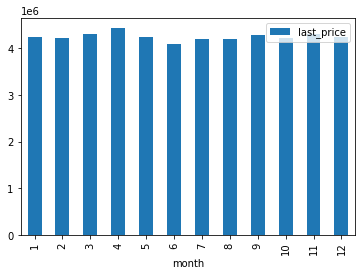

In [162]:
new_data_month = new_data.pivot_table(index='month', values='last_price', aggfunc='median')
print(new_data_month)
new_data_month.plot(y='last_price', kind='bar')

# print(data['month'].corr(data['last_price']))
# data.plot(x='month', y='last_price', kind='scatter')


В мае и июне объекты недвижимости продаются немного дешевле, чем в остальные месяцы. И наоборот в марте и апреле пик стоимости проданных объектов недвижимости.

#### Зависимость цены от года

      last_price
year            
2014     4600000
2015     4590000
2016     4150000
2017     4140000
2018     4200000
2019     4600000


<AxesSubplot:xlabel='year'>

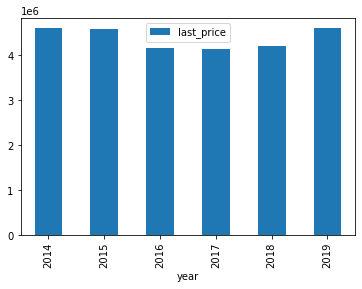

In [163]:
new_data_year = new_data.pivot_table(index='year', values='last_price', aggfunc='median')
print(new_data_year)
new_data_year.plot(y='last_price', kind='bar')

# new_data_year.boxplot(grid=True)

# print(data['year'].corr(data['last_price']))
# data.plot(x='year', y='last_price', kind='scatter')

в 2019 и 2014 году недвижимость продавалась гораздо дороже, чем, например в 2016 и 2017 годах.

### Выберите 10 населённых пунктов с наибольшим числом объявлений.
Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце locality_name.

In [164]:
top10_location_data = (data.pivot_table(index='locality_name', values='cost_meter', aggfunc=('mean','count'))
    .sort_values(by='count', ascending=False))
display(top10_location_data.head(10).sort_values(by='mean'))

# print('Населённый пункт с самой высокой стоимостью жилья в', data['last_price'].max(), 'рублей:')
# print(data[data['last_price'] == data['last_price'].max()]['locality_name'])

# print('Населённый пункт с самой низкой стоимостью жилья в', data['cost_meter'].min(), 'рублей:')
# print(data[data['last_price'] == data['last_price'].min()]['locality_name'])

,count,mean
locality_name,,
Выборг,237,58141.909153
Всеволожск,398,68654.473986
Гатчина,307,68746.146763
Колпино,338,75424.579098
посёлок Шушары,440,78677.364217
посёлок Мурино,522,85752.189195
посёлок Парголово,327,90175.913458
деревня Кудрово,299,92473.547576
Пушкин,369,103125.819291


Определили список ТОП-10 населенных пунктов с наибольшим числом объявлений и отсортировали получений список по средней стоимости квадратного метра. Можно сказать, что в Питере самое большее число объявлений и самая дорогая средняя стоимость квадратного метра в полученном списке.
Минимальная средняя стоимость квадратного метра в Выборге.

### Изучите предложения квартир: 
для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (locality_name). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется, — это и будет центральная зона.

In [165]:
display(new_data['cityCenters_nearest'].isna().sum())

5225

В новом датафрейме без критических и выбивающихся значений есть 5225 пропусков по столбцу cityCenters_nearest. Заполним его медианным значением.

In [166]:
cityCenters_median = new_data['cityCenters_nearest'].mean()
new_data['cityCenters_nearest'] = new_data['cityCenters_nearest'].fillna(cityCenters_median)

,last_price
cityCenters_km,
0,6.466667e+06
1,7.844686e+06
2,7.553296e+06
3,6.906314e+06
4,7.067099e+06
5,7.404745e+06
6,6.961006e+06
7,6.543460e+06
8,6.222743e+06


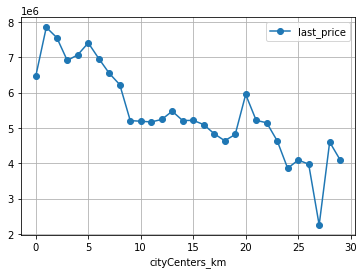

In [167]:
def m_to_km(row):
    meters = row['cityCenters_nearest']
    return round(meters / 1000)

new_data['cityCenters_km'] = new_data.apply(m_to_km, axis=1)

# piter_data = data.query('locality_name == Санкт-Петербург')
piter_data = new_data[new_data['locality_name'] == 'Санкт-Петербург']
piter_data_avg = (
    piter_data.pivot_table(index='cityCenters_km', values='last_price')
)

piter_data_avg.plot(y='last_price', style='o-', grid=True)
display(piter_data_avg.head(20))#.sort_values(by='mean'))


In [168]:
# код ревьюера
round(400/1000)

0

Из графика распределения средней стоимсоти недвижимости в зависимсти от расстояния до центра (км), мы видим несколько пиковых значений. Стоимость жилья в радиусе 3км от центра немного "просидает", возможно это обусловлено каким-то географическим фактором. Шумный район, шоссе и т.д., поэтому стоимость жилья в этом радиусе существенно меньше. Но потом опять наблюдается подъем цен за объекты недвижимости и резкое изменение цены мы наблюдаем после 7км и дальше. После 7км есть еще несколько пиков, но уже значительно меньше, чем предыдущий. Это может быть обусловлено возможно тем, что там появляются новые районы, на которые тоже соответсвенно появляется спрос, и резко возрастает цена на недвижимость в этом радиусе.

Определяем центр "Питера" - 7км

### Выделите сегмент квартир в центре.
Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?

#### Изучите следующие параметры:
площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

In [169]:
# Создаём нашу таблицу с недвижимостью в центре Питера
piter7km_data = piter_data.query('cityCenters_km <= 7').reset_index(drop=True)
# display(piter7km_data.head(20))

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

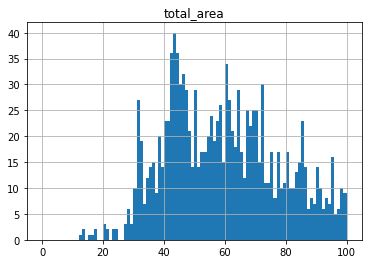

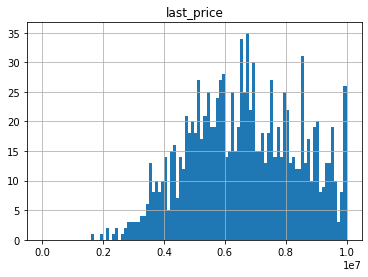

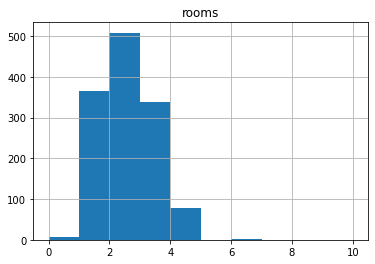

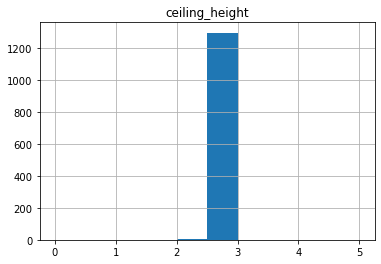

In [170]:
# Гистрограмма для площади
piter7km_data.hist('total_area', bins=100, range=(0, 100))

# Гистрограмма для wtys
piter7km_data.hist('last_price', bins=100, range=(0, 10000000))

# Гистрограмма для числа комнат
piter7km_data.hist('rooms', range=(0,10))

# Гистрограмма для высоты потолков
piter7km_data.hist('ceiling_height', bins=10, range=(0,5))


Выводы по полному датасету:
* Большая часть недвижимости от 25 до 75 квадратов, пик в 40-50 квадратов
* Большая часть недвижимости в датасете стоит от 2,5 до 6млн рублей, пик 3-4млн рублей
* Больше всего продаются жил. площади с 1-2 комнатами и не сильно уступают им 3х комнатные
* Больше всего недвижимости с потолками от 2,5 до 3 метров

Выводы по датасету с недвижимостью в центре Питера:
* Пик в 40-50 квадратов
* Пик в 6,5-7млн рублей
* Больше всего продаются жил. площади с 2 комнатами, затем 1-комнатные, затем 3х комнатные
* Все потолки от 2,5 до 3 метров

Из данных показателей можно сделать вывод, что в центре Санк-Петербурга спрос на желаемую квадратуру такой же, как и во всем Санкт-Петерубрге, но пиковая цена выше на 2,5-3млн рублей, спрос по количеству комнат тоже меняется, и высота потолков в продаваемых постройках приобретает более однозначный характер.

#### Зависимость цены от площади

0.6772886526996743
0.7079583624909674


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

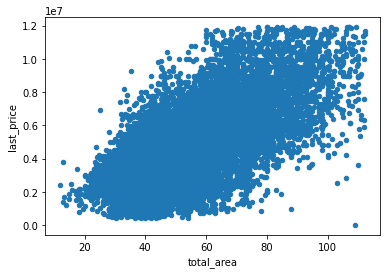

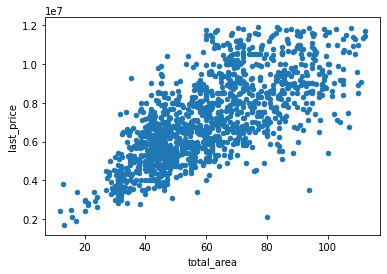

In [171]:
print(new_data['total_area'].corr(new_data['last_price']))
new_data.plot(x='total_area', y='last_price', kind='scatter')
print(piter7km_data['total_area'].corr(piter7km_data['last_price']))
piter7km_data.plot(x='total_area', y='last_price', kind='scatter')

В целом, видим, что распределение зависимости цены от площади жилья практически такая же, как и у всего датафрейма по Санкт-Петербургу. Единственное, на графике с "центром Питера" мы отчетлевее можем наблюдать, что вероятность низкой цены с увеличением площади значительно падает, чем в полном датасете.

#### Зависимость цены от количества комнат

<AxesSubplot:xlabel='rooms'>

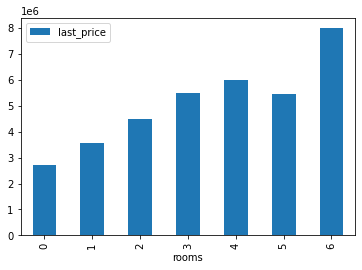

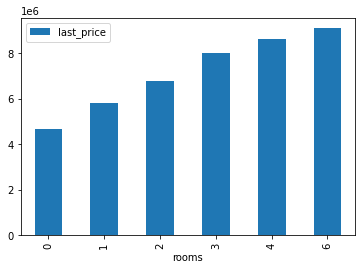

In [172]:
new_data_rooms = new_data.pivot_table(index='rooms', values='last_price', aggfunc='median').sort_values(by='rooms')
#display(new_data_rooms)
new_data_rooms.plot(y='last_price', kind='bar')

new_piter7km_data_rooms = piter7km_data.pivot_table(index='rooms', values='last_price', aggfunc='median').sort_values(by='rooms')
#display(new_piter7km_data_rooms)
new_piter7km_data_rooms.plot(y='last_price', kind='bar')

Зависимость цены от количества комнат уже меняется. Во-первых, в центре Питера (7км) одномнатные объекты недвижимости стоят в среднем на 1млн дороже априори. И можно заметить хрошо росматриваемую закономерность, что с увеличением количества комнат растёт и цена.

#### Зависимость цены от расстояния до центра

-0.24502760183041436
-0.09518020484921133


<AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>

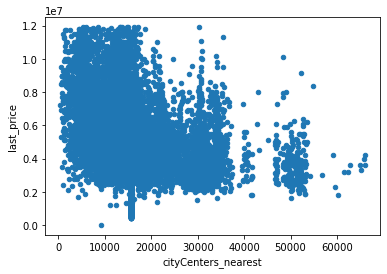

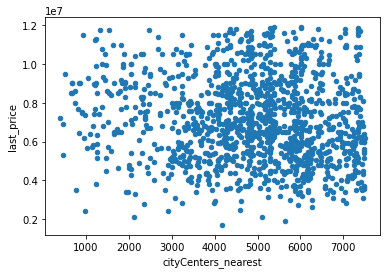

In [178]:
print(new_data['cityCenters_nearest'].corr(new_data['last_price']))
new_data.plot(x='cityCenters_nearest', y='last_price', kind='scatter')

print(piter7km_data['cityCenters_nearest'].corr(piter7km_data['last_price']))
piter7km_data.plot(x='cityCenters_nearest', y='last_price', kind='scatter')

В данном случае зависимости уже не такие одниаковые. Явная прямопропорциональная зависимость не наблюдается в датасете по центру Питера. Единственное, что можно отметить - начиная примерно от 3км - диапозон цен за недвижимость гораздо шире и насыщеннее.

#### Зависимость цены от этажности

<AxesSubplot:xlabel='floor_type'>

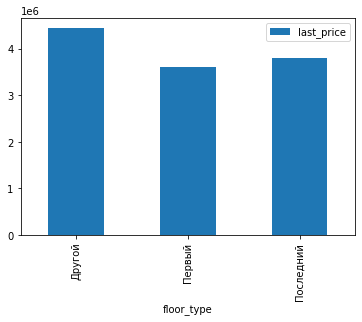

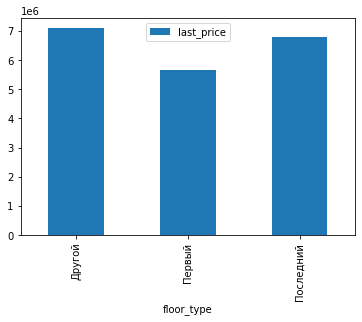

In [179]:
new_data_floor = new_data.pivot_table(index='floor_type', values='last_price', aggfunc='median').sort_values(by='floor_type')
#display(new_data_floor)
new_data_floor.plot(y='last_price', kind='bar')

new_piter7km_data_floor = piter7km_data.pivot_table(index='floor_type', values='last_price', aggfunc='median').sort_values(by='floor_type')
#display(new_piter7km_data_floor)
new_piter7km_data_floor.plot(y='last_price', kind='bar')

Общая закономерность по тажности в двух датасетах осталась примерно одинаковой. Но можно отметить, то что в центре Питере недвижимость на "другом" этаже стоит практически на 1млн больше. Недвижимость на первом и последних этажах в центре Питера тоже стоят дороже, чем в полном датасете, но примерно на 0.7 млн. Плюс Стоимость последнего этажа практическая такая же, как и любого другого этажа, кроме первого.

#### Зависимость цены от дня недели

<AxesSubplot:xlabel='weekday'>

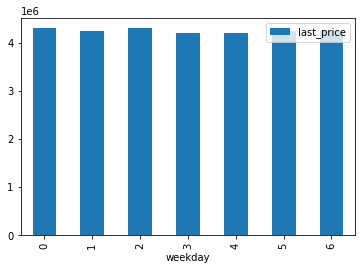

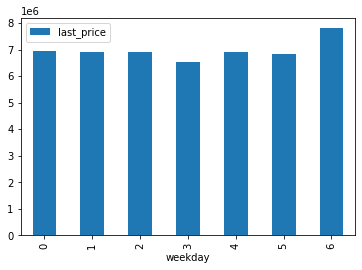

In [180]:
new_data_weekday = new_data.pivot_table(index='weekday', values='last_price', aggfunc='median')
# print(new_data_weekday)
new_data_weekday.plot(y='last_price', kind='bar')

new_piter7km_data_weekday = piter7km_data.pivot_table(index='weekday', values='last_price', aggfunc='median')
# print(new_piter7km_data_weekday)
new_piter7km_data_weekday.plot(y='last_price', kind='bar')

Если в полном датасете трудно на взгляд определить дни недели, в которые недвижимость продается дороже, чем в другие, то в датасете по центру Питера можно с уверенностью сказать, что недвижимость, проданная в воскресенье стоит значительно больше, чем, нпаример, в среду.

#### Зависимость цены от месяца

<AxesSubplot:xlabel='month'>

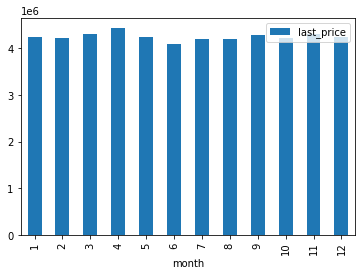

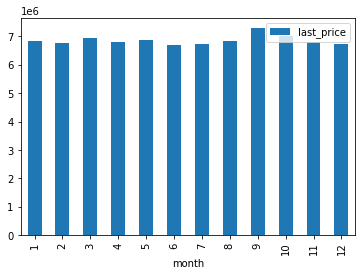

In [181]:
new_data_month = new_data.pivot_table(index='month', values='last_price', aggfunc='median')
# print(new_data_month)
new_data_month.plot(y='last_price', kind='bar')

new_piter7km_data_month = piter7km_data.pivot_table(index='month', values='last_price', aggfunc='median')
# print(new_piter7km_data_month)
new_piter7km_data_month.plot(y='last_price', kind='bar')

Похожая ситуация как и на графиках с днями недели. По графику на датасете центра Питера видно что в сентбяре недвижимость продаётся гораздо дороже, чем, например в июне и августе.

#### Зависимость цены от года

<AxesSubplot:xlabel='year'>

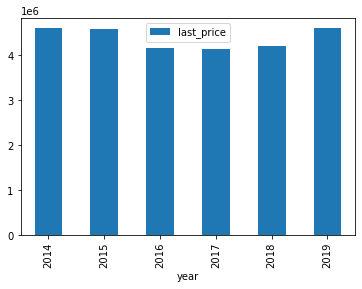

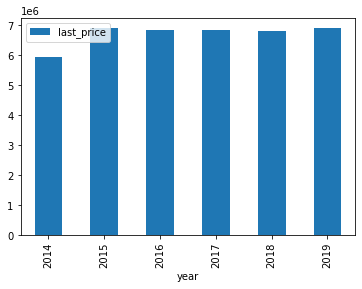

In [182]:
new_data_year = new_data.pivot_table(index='year', values='last_price', aggfunc='median')
# print(new_data_year)
new_data_year.plot(y='last_price', kind='bar')

new_piter7km_data_year = piter7km_data.pivot_table(index='year', values='last_price', aggfunc='median')
# print(new_piter7km_data_year)
new_piter7km_data_year.plot(y='last_price', kind='bar')

На полученном графике по центру Питера, видим, что последние 5 лет цена практически никак не изенялась. Была практически одинаковой во всех годах. А вот в 2014 стоила гораздо дешевле

## Общий вывод

Проведя исследовательский анализ по продаже недвижимости за определенный период времени, можно сказать, что:
1. Есть небольшая прямопропорциональная зависимость цены от площади объекта, от близости к центру.
2. Есть небольшая тенденция частоты покупки квартир с 1-3 комнатами и на всех этажа, кроме первого.
3. Отсутствует какая-либо зависиость цены от даты, дня недели, года продажи объяекта.
4. Выводы о наличии и отсуствии зависимости цены от какого-либо фактора так же распространяются и на недвижимость в центре Питербурга (до 7км), с небольшим отличием в конкретных показателях (пиках) по ряду признаков.

Таким образом, можно составить "идеальный объект недвижимости" для продажи в Санкт-Петербурге и отдельно в радиусе 7км от центра Санкт-Петербурга:
1. Высокую цену может иметь недвижимость во всем Петербурге, если удовлетворяет этим харакеристикам:
* Общая площадь составляет от 25 до 50квадратов
* Стоимость не превышает 2,5-5 млн рублей
* Это 1-2-комнатная квартира не на первом этаже, с потолками от 2,5 до 3 метров.

2. Высокую цену может иметь недвижимость в радиусе 7км от центра Петербурга, если удовлетворяет этим харакеристикам:
* Общая площадь так же составляет от 40 до 50квадратов
* Стоимость не превышает 6,5-7 млн рублей
* Это 2-комнатная квартира не на первом этаже, с потолками от 2,5 до 3 метров.